In [42]:
import os
import json
import sys
import glob

import numpy as np
import pandas as pd

import torch
import torchvision

import matplotlib.pyplot as plt
import lightning as L
from lightning.pytorch.utilities.model_summary import ModelSummary

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from data_module.data_module import ALDataModule_v1, FFTDataModule
from utils.data_utils import limit_filter_data_by_class
from utils.model_utils import reset_weight_model, unwrap_model
from utils.TSNE import get_tsne, scatter_tsne

from model.classifier_model import Classifier1DMaxPoolBNModel, Classifier1D

from config.optimizer_param_config import optimizer_param_dict
from config.channel_param_config import channel_param_dict


In [43]:
import argparse

parser = argparse.ArgumentParser(description="", formatter_class=argparse.ArgumentDefaultsHelpFormatter)

parser.add_argument('-ck', "--checkpoint_path", type=str, default="/nfs/ksdata/tran/HAR_AE/lightning_logs/10.3_classify/4cnn_64-8-100-1/version_0/checkpoints/sample_epoch=89-step=90-val_loss=1.038441.ckpt", 
                    help=f"AL learning model checkpoint. If you do not have any ckpt of model. You should consider running classifier notebook to create one")

parser.add_argument('-m', "--method", type=str, default="sampling",
                    help=f":: select run method from [random, sampling, full]")

parser.add_argument("-sh", "--sampling_heuristic", type=str, default="uncertainty",
                    help=f"""heuristic function in case the method is sampling:: [uncertainty, entropy, margin],
                    ref: https://github.com/baal-org/baal/blob/master/baal/active/heuristics/heuristics.py#L512""")

parser.add_argument("-ss", "--sampling_size", type=int, default=100,
                    help=f"sampler size to take from additional dataset. normally < 5000, Not effective for method `full`")

parser.add_argument("-tl", "--train_limit_data", type=int, default=500,
                    help=f"Used for limit the number of data in train data, -1 mean no limit")

parser.add_argument("--filter_unselected_data_num", type=int, default=5000,
                    help=f"Used for get the size of additional dataset")

parser.add_argument("--reset_weight", type=int, default=1,
                    help=f"Reset weight before training. If not reset, we will continue learning from the checkpoint")

parser.add_argument("-r", "--random_seed", type=int, default=42,
                    help=f"Random Seed")

parser.add_argument("--eval_mode", type=int, default=0,
                    help=f"Eval all models")

if os.path.basename(sys.argv[0]) == 'ipykernel_launcher.py':
    args = parser.parse_args(args=[])
else:
    args = parser.parse_args()

In [44]:
L.seed_everything(42)

Seed set to 42


42

In [45]:
n_epochs = 2000000
patience = n_epochs//5000

optimizer, optimizer_param = optimizer_param_dict["Adam"]

log_save_dir = "lightning_logs"
reset_str = "_reset" if args.reset_weight else ""
    
log_save_name = f"16.3_AL_v4_500lim/{args.method}_{args.sampling_heuristic}_{args.sampling_size}_{args.random_seed}_{reset_str}"

In [46]:
net = Classifier1DMaxPoolBNModel.load_from_checkpoint(args.checkpoint_path)

model_summary = ModelSummary(net, max_depth=6)
print(model_summary)

   | Name     | Type        | Params | In sizes     | Out sizes   
------------------------------------------------------------------------
0  | cnn      | Sequential  | 316 K  | [10, 6, 257] | [10, 256, 1]
1  | cnn.0    | Conv1d      | 1.6 K  | [10, 6, 257] | [10, 32, 84]
2  | cnn.1    | BatchNorm1d | 64     | [10, 32, 84] | [10, 32, 84]
3  | cnn.2    | ReLU        | 0      | [10, 32, 84] | [10, 32, 84]
4  | cnn.3    | Conv1d      | 18.5 K | [10, 32, 84] | [10, 64, 26]
5  | cnn.4    | BatchNorm1d | 128    | [10, 64, 26] | [10, 64, 26]
6  | cnn.5    | ReLU        | 0      | [10, 64, 26] | [10, 64, 26]
7  | cnn.6    | Conv1d      | 65.7 K | [10, 64, 26] | [10, 128, 7]
8  | cnn.7    | BatchNorm1d | 256    | [10, 128, 7] | [10, 128, 7]
9  | cnn.8    | ReLU        | 0      | [10, 128, 7] | [10, 128, 7]
10 | cnn.9    | Conv1d      | 229 K  | [10, 128, 7] | [10, 256, 1]
11 | cnn.10   | BatchNorm1d | 512    | [10, 256, 1] | [10, 256, 1]
12 | cnn.11   | ReLU        | 0      | [10, 256, 1] | [1

In [47]:
def process_tl_and_additional_ds(data_module):
    assert args.train_limit_data + args.filter_unselected_data_num < np.max(np.unique(data_module._train_label, return_counts=True)[1])
    
    data_module.limit_and_set_train_data(data_module._train_data, data_module._train_label, limit_number=args.train_limit_data)
    print("data_module.choice_limited_list", data_module.choice_limited_list[:10])
    
    unselected_train_idx = list(set(range(len(data_module._train_label))) - set(data_module.choice_limited_list))
    unselected_train_data = data_module._train_data[unselected_train_idx]
    unselected_train_label = data_module._train_label[unselected_train_idx]

    filter_data, filter_label, choice_idx = limit_filter_data_by_class(unselected_train_data, unselected_train_label, args.filter_unselected_data_num)
    return filter_data, filter_label, choice_idx
    

In [52]:
assert args.method in [ "sampling",  "random" ]
data_module = ALDataModule_v1.load_from_checkpoint(args.checkpoint_path, prefix="torso_", postfix="_fft", sampler_heuristic=args.sampling_heuristic, sampler_size=args.sampling_size)

def generate_sampling_datamodule(data_module):
        
    if args.method == "sampling":
        # Add to training dataset the uncertainty data for later training
        trainer = L.Trainer()
        # data_module = ALDataModule_v1(dataset_path=dataset_path, batch_size=512, prefix="torso_", postfix="_fft")
        
        _additional_data, _additional_label, _additional_choice_idx = process_tl_and_additional_ds(data_module)
        data_module.set_train_val_test_pred_data(pred_data=_additional_data)
        
        output = trainer.predict(model=net, datamodule=data_module)
        
        data_module.limit_and_set_train_val_test_pred_data(
            data_module._train_data,
            data_module._train_label,
            train_limit_number = args.train_limit_data,
            seed=42)
        
        data_module.set_unsertainty_set(data=_additional_data, label=_additional_label, net_output=output)
        
        data_module.limit_and_set_train_val_test_pred_data(
            val_data=data_module._val_data,
            val_label=data_module._val_label,
            test_data=data_module._test_data,
            test_label=data_module._test_label,
            val_limit_number=100,
            test_limit_number=100,
            seed=42)
        
        print("data_module.sampling_rank", data_module.sampling_rank[:10])
    
    elif args.method == "random":
        # data_module = ALDataModule_v1.load_from_checkpoint(args.checkpoint_path, prefix="torso_", postfix="_fft", sampler_size=args.sampling_size)
        _additional_data, _additional_label, _additional_choice_idx = process_tl_and_additional_ds(data_module)
        
        data_module.limit_and_set_train_val_test_pred_data(
            data_module._train_data,
            data_module._train_label,
            data_module._val_data,
            data_module._val_label,
            data_module._test_data,
            data_module._test_label,
            train_limit_number =args.train_limit_data,
            val_limit_number=100,
            test_limit_number=100,
            seed=42)
    
        data_module.set_random_set(data=_additional_data, label=_additional_label)
        print("data_module.sampling_rank", data_module.random_rank[:10])

    return data_module

data_module = generate_sampling_datamodule(data_module)


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 138.77it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [13081 13915 14955 11717 13197 14150 14666 15352 13000  9798]


In [53]:
## Reset net weight before training
L.seed_everything(args.random_seed)
if args.reset_weight:
    reset_weight_model(net, verbose=1)

Seed set to 42


reset <class 'torch.nn.modules.conv.Conv1d'>
reset <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
reset <class 'torch.nn.modules.conv.Conv1d'>
reset <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
reset <class 'torch.nn.modules.conv.Conv1d'>
reset <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
reset <class 'torch.nn.modules.conv.Conv1d'>
reset <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
reset <class 'torch.nn.modules.linear.Linear'>
reset <class 'torch.nn.modules.batchnorm.BatchNorm1d'>
reset <class 'torch.nn.modules.linear.Linear'>


In [54]:
if not args.eval_mode:
    print(" ----------------------start training---------------------------")
    from lightning.pytorch.callbacks.early_stopping import EarlyStopping
    from lightning.pytorch.callbacks import ModelCheckpoint
    from lightning.pytorch.loggers import TensorBoardLogger, CSVLogger
    
    tensorboard_logger = TensorBoardLogger(save_dir=log_save_dir, name=log_save_name,)
    csv_logger = CSVLogger(save_dir=log_save_dir, name=log_save_name,)
    checkpoint_callback = ModelCheckpoint(
        dirpath=None,
        save_top_k=1,
        monitor="val_loss",
        mode="min",
        filename="sample_{epoch:02d}-{step:02d}-{val_loss:02f}"
    )
    
    trainer = L.Trainer(
        logger=[tensorboard_logger, csv_logger],
        callbacks=[EarlyStopping(monitor="val_loss", patience=patience), checkpoint_callback],
        max_epochs=n_epochs,
        check_val_every_n_epoch=10,
        accelerator="gpu",
        )
    
    trainer.fit(model=net, datamodule=data_module)
    trainer_test_dict = trainer.logged_metrics
    
    trainer.test(model=net, datamodule=data_module)
    trainer_test_dict.update(trainer.logged_metrics)
    
    for key in trainer_test_dict.keys():
        trainer_test_dict[key] = trainer_test_dict[key].item()
    
    with open(os.path.join(trainer.logger.log_dir, "result.json"), "w") as f:
        json.dump(trainer_test_dict, f, indent=4)
    
    with open(os.path.join(trainer.logger.log_dir, "argparse_params.json"), "w") as f:
        json.dump(args.__dict__, f, indent=4)

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type       | Params | In sizes     | Out sizes   
--------------------------------------------------------------------
0 | cnn    | Sequential | 316 K  | [10, 6, 257] | [10, 256, 1]
1 | linear | Sequential | 17.1 K | [10, 256]    | [10, 8]     
--------------------------------------------------------------------
333 K     Trainable params
0         Non-trainable params
333 K     Total params
1.334     Total estimated model params size (MB)


 ----------------------start training---------------------------
                                                                                                                                                                                                                                                 

/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (9) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 56.69it/s, v_num=4_5, train_loss=0.948]
Validation: |                                                                                                                                                                                                              | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 61.34it/s, v_num=4_5, train_loss=0.497, val_loss=0.911, val_acc=0.686]
Validation: |                                                                                                                                                                                                              | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|█████████████████

/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 85.68it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.625
        test_loss           0.9705338478088379
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [55]:
args.eval_mode = 1
if args.eval_mode:
    reset_str = "_reset"
    lightning_save_dir = f"lightning_logs/16.3_AL_v4_500lim/"
    result_save_dict = {}
    sampling_size_list = list(map(int, "200 400 800".split(" ")))
    raw_result_save_dict = {}
    
    for args.method in ["random", "sampling"]:
        if args.method == "random":
            heuristic_list = ["uncertainty"]

        else:
            heuristic_list = ["uncertainty", "entropy", "margin"]
        
        for args.sampling_heuristic in heuristic_list:
            for args.sampling_size in sampling_size_list:
                for args.random_seed in "42 64".split(" "):
                    save_model_folder = f"{args.method}_{args.sampling_heuristic}_{args.sampling_size}_{args.random_seed}_{reset_str}"
                    print(save_model_folder)
                    save_model_dir = os.path.join(lightning_save_dir, save_model_folder)
                    
                    weight = glob.glob(os.path.join(save_model_dir, "version_0", "checkpoints", "*.ckpt"))[0]
    
                    net = Classifier1DMaxPoolBNModel.load_from_checkpoint(weight)
                    data_module = ALDataModule_v1.load_from_checkpoint(weight)
                    data_module = generate_sampling_datamodule(data_module)
    
                    trainer = L.Trainer()
                    trainer.test(model=net, datamodule=data_module, verbose=False)
                    test_acc = trainer.logged_metrics["test_acc"]
    
                    result_save_dict[save_model_folder] = test_acc.item()

                    output = trainer.predict(model=net, datamodule=data_module)
                    pred = torch.argmax(torch.concat(output), dim=1)
                    gt = list(map(lambda x: x[1], iter(data_module.test_dataloader())))
    
                    pred_ravel = pred.numpy()
                    gt_ravel = np.concatenate(list(map(lambda x: x.numpy(), gt)))
    
                    cf = confusion_matrix(gt_ravel, pred_ravel)
                    
                    raw_result_save_dict[save_model_folder] = cf.tolist()


random_uncertainty_200_42__reset
limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [18207 21088 13538 24705 34880 21925 14404  9094 32657 30380]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
set_random_set
data_module.sampling_rank [28424 23153 14840 23484 38227 15074  6161  5747 23993 17220]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 140.62it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 179.41it/s]
random_uncertainty_200_64__reset
limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [25995 37497 15712 60791 55473 47170 16755 46134 31772  6524]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
set_random_set
data_module.sampling_rank [28424 23153 14840 23484 38227 15074  6161  5747 23993 17220]


/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 116.08it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 166.18it/s]
random_uncertainty_400_42__reset
limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [25995 37497 15712 60791 55473 47170 16755 46134 31772  6524]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
limit_filter_data_by_class limit_number= 100
limi

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


data_module.sampling_rank [28424 23153 14840 23484 38227 15074  6161  5747 23993 17220]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 118.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 132.65it/s]
random_uncertainty_400_64__reset
limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [25995 37497 15712 60791 55473 47170 16755 46134 31772  6524]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
limit_filter_data_by_class limit_number= 100
limi

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not h

Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 120.86it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 149.76it/s]
random_uncertainty_800_42__reset
limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [25995 37497 15712 60791 55473 47170 16755 46134 31772  6524]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
set_random_set
data_module.sampling_rank [28424 23153 14840 23484 38227 15074  6161  5747 23993 17220]


IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 156.13it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 185.85it/s]
random_uncertainty_800_64__reset
limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [25995 37497 15712 60791 55473 47170 16755 46134 31772  6524]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
set_random_set
data_module.sampling_rank [28424 23153 14840 23484 38227 15074  6161  5747 23993 17220]


/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 111.68it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 145.14it/s]
sampling_uncertainty_200_42__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [25995 37497 15712 60791 55473 47170 16755 46134 31772  6524]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 155.67it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [ 7108 29640 19257 20921 36597 15881 22613  7850  6897 38834]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 112.05it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 201.70it/s]
sampling_uncertainty_200_64__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 171.80it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [32535 22796 26542 22499 39029 24341 34544 27517 25653 15774]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 121.97it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 136.73it/s]
sampling_uncertainty_400_42__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 180.37it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [ 6541 24275 28708 15201 17125 29036 38577 38500 29582 27904]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 125.42it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 218.14it/s]
sampling_uncertainty_400_64__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 141.87it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [19351 18684 18620 39029 15762 18378 19109  4758 15636 17416]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 108.07it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 160.72it/s]
sampling_uncertainty_800_42__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 145.01it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [20260 17640 14694 15044 22132 26735 20610 21672 20229 39029]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 102.25it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 212.63it/s]
sampling_uncertainty_800_64__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 154.19it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [39891 30600 18626 30615 33899 39106 24275 19334 15879 16898]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 104.24it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 174.04it/s]
sampling_entropy_200_42__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 150.70it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [23707 32589 26111  8662 39211 17427 38792 17900  3546 22405]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 109.72it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 159.18it/s]
sampling_entropy_200_64__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 134.89it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [ 3167 30375 16676   258 16565 15083 18572 18214 36307 16098]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 112.60it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 173.65it/s]
sampling_entropy_400_42__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 164.96it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [27245 36584 32862 27951 28959 38088 34883 29333 30860 27636]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 143.92it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 203.86it/s]
sampling_entropy_400_64__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 160.98it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [27675  6811 16333 19248 19617   689 18378 26688 35002 39201]
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 94.31it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 173.40it/s]
sampling_entropy_800_42__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 132.19it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [18659 24318 15054 33636 38243 32997 27725  2809 20350  1711]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 132.11it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 194.81it/s]
sampling_entropy_800_64__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 160.60it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [16944 34117 16549  4002 29873   993 35441 39840 32261 28701]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 110.86it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 169.28it/s]
sampling_margin_200_42__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 127.99it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [    5 37721  1241 33020  2710 22333 31213 37647 25311  4279]
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 92.99it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 161.85it/s]
sampling_margin_200_64__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 123.22it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [ 3560 32808 27455   320 34237  4066 33111 35246 23567 39151]


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 112.11it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 162.29it/s]
sampling_margin_400_42__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 140.68it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [ 4272 31829 34170  3228 32943  3104 36177  7062 37174 37888]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 130.40it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 197.99it/s]
sampling_margin_400_64__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 132.66it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [22618 21073 34154 38491 37791 28808 30412 23058 30053 39110]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 123.51it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 188.77it/s]
sampling_margin_800_42__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 128.84it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [30800 25665 36856 32176 32179 30504 30777 29425 34388  4286]
Testing DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 88.60it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 191.50it/s]
sampling_margin_800_64__reset


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/pyth ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


limit_and_set_train_data limit_number= 500
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
data_module.choice_limited_list [56426  1336 17148 31823 45594 19119 29815 16311   589 46761]
limit_filter_data_by_class limit_number= 5000
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 144.30it/s]
set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 500
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([500, 500, 500, 500, 500, 500, 500, 500]))
set_unsertainty_set


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/nfs/ksdata/tran/miniconda3/envs/python_3.8/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=55` in the `DataLoader` to improve performance.


set_train_val_test_pred_merge_data
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
limit_filter_data_by_class limit_number= 100
limit_filter_data_by_class:  (array([1., 2., 3., 4., 5., 6., 7., 8.]), array([100, 100, 100, 100, 100, 100, 100, 100]))
data_module.sampling_rank [17781 30527   502 36177  1802 35208 21196 15482 26560 36532]
Testing DataLoader 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 127.01it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 192.61it/s]


In [58]:
raw_result_save_dict
with open("save_data/16.3_AL_500lim.json", "w") as f:
    json.dump(raw_result_save_dict, f, indent=2)

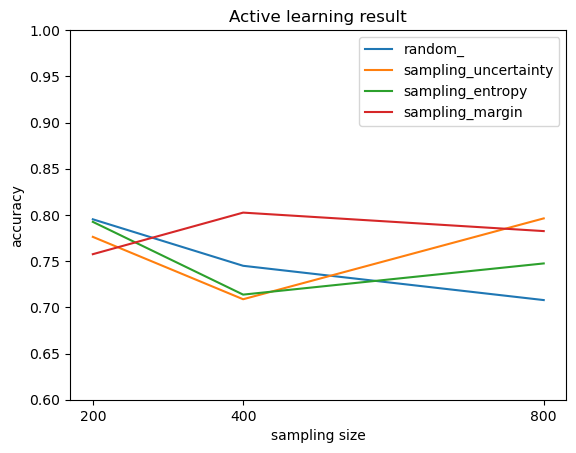

In [60]:
if args.eval_mode:
    reset_str = "_reset"
    args.random_seed = "64"
    sampling_size_list = list(map(int, "200 400 800".split(" ")))

    for args.method in ["random", "sampling"]:
        if args.method == "random":
            heuristic_list = ["uncertainty"]
        else:
            heuristic_list = ["uncertainty", "entropy", "margin"]
        for args.sampling_heuristic in heuristic_list:
            sampling_y = []
            
            for args.sampling_size in sampling_size_list:
                save_model_folder = f"{args.method}_{args.sampling_heuristic}_{args.sampling_size}_{args.random_seed}_{reset_str}"
                sampling_y.append(result_save_dict[save_model_folder])

            if args.method == "random": args.sampling_heuristic=""
            plt.plot(sampling_size_list, sampling_y, label=f"{args.method}_{args.sampling_heuristic}")

    plt.ylim(0.6, 1)
    plt.legend()
    plt.xticks(sampling_size_list)
    plt.xlabel("sampling size")
    plt.ylabel("accuracy")
    plt.title("Active learning result")
            
                